GAN : 생성자가 이미지를 만들고, 판별자가 가짜인지 진짜인지 판별하여, 계속 경쟁적으로 가짜이미지를 진짜와 비슷하게 만들어낸다.

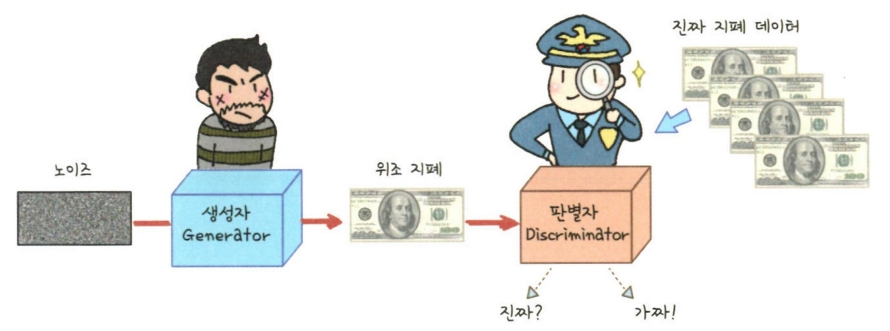

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
# 생성자 
generator = keras.Sequential()
# Dense 부터 생성한다.( input_dim은 랜덤하게 적당히 넣어준다. 딱히 값이 커도 성능이 좋아지진 않는다.)
# 7 * 7 로 한 이유는 나중에 upsampling으로 2배를 곱하고, 다시 upsamepling을 해서 2배, 즉 4 * 7 = 28로 늘리기 때문이다.
# 한 번에 늘리지 않고, 조금씩 늘리는 것이 DCGAN의 특징이다.
generator.add(keras.layers.Dense(7*7*128, input_dim = 100,
                                 activation = keras.layers.LeakyReLU(alpha = 0.2)))
# 전체 데이터를 평균 분산으로 만들어준다. Z trainsform이라고도 한다.
# 일반적으로는 BatchNormalization을 먼저 끝내고 Dense로 받는 것도 있다. 순서에 대해서는 확인이 필요.
generator.add(keras.layers.BatchNormalization())

# 1차원(y)의 배열을 3차원(x, y, z)의 배열로 변경해준다.   
generator.add(keras.layers.Reshape((7, 7, 128))) 

# 이미지를 가로 2배, 세로 2배로 늘린다. 
generator.add(keras.layers.UpSampling2D())
# CNN 
generator.add(keras.layers.Conv2D(64, kernel_size = 5, padding = 'same'))

# 다시 평균분산으로 만든다.
generator.add(keras.layers.BatchNormalization())

# 활성화 함수 LeakyReLU를 실행하기 위해서 Layer 추가
generator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))

# 2배 늘리기
generator.add(keras.layers.UpSampling2D())

# 가장 마지막에 tamh를 사용한다.
# fake image 1장이 나와야 하기 때문에 1개의 output 설정
generator.add(keras.layers.Conv2D(1, kernel_size = 5, 
                                  padding = 'same', activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [ ]:
# 판별자
discriminator = keras.Sequential()
discriminator.add(keras.layers.Conv2D(64, kernel_size = 5, strides = 2,
                                      input_shape= (28, 28, 1), padding = 'same'))
discriminator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))

discriminator.add(keras.layers.Conv2D(128, kernel_size = 5, strides = 2,
                                      input_shape= (28, 28, 1), padding = 'same'))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation='sigmoid'))

discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam',
                      metrics = 'accuracy')
discriminator.trainable = False
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
_________________________________________________________________


In [ ]:
#목적 : gan의 생성자와 판별자를 연결한다.
ginput = keras.layers.Input(shape = (100, ))
dis_output = discriminator(generator(ginput))

# gan 모델에 생성자, 판별자를 넣는다.
gan = keras.models.Model(ginput, dis_output)

gan.compile(loss = 'binary_crossentropy', optimizer = 'adam',
           metrics = 'accuracy') # print에 이슈가 있다면 metrics = accuracy 부분은 제거해준다.

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [ ]:
def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_,_) = keras.datasets.mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
    x_train = (x_train - 127.5)/127.5

    true = np.ones((batch_size, 1))
    # fake 이미지가 잘 안 만들어지면 이부분이 ones로 되어서 그런 것 같다.
    fake = np.zeros((batch_size, 1))

    d_losses = []
    g_losses = []

    for i in range(epoch):
        # real training loss
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # generator loss
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    # 판별자와 생성자의 오차 계산
        d_loss = np.add(d_loss_real, d_loss_fake)/2
        g_loss = gan.train_on_batch(noise, true)

        d_losses.append(d_loss)
        g_losses.append(g_loss)

        print('epoch: ', i, ' d_loss: ', d_loss, ' g_loss:', g_loss)


        # 그 때 만든 이미지를 gan images 폴더에 저장하라는 뜻,

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_images = generator.predict(noise)
            
            #Rescale images 0 ~ 1
            gen_imgs = gen_images*0.5 - 0.5

            fig, axe = plt.subplots(5, 5)

            count = 0
            for j in range(5):
                for k in range(5):
                    axe[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
                    axe[j, k].axis('off')

                    count += 1
            fig.savefig('gan_images/gan_mnist_%d.png' % i)
    return d_losses, g_losses

epoch:  0  d_loss:  [0.83071798 0.234375  ]  g_loss: [0.3016636371612549, 1.0]
epoch:  1  d_loss:  [0.54156476 0.5       ]  g_loss: [0.3500227928161621, 1.0]
epoch:  2  d_loss:  [0.45256215 0.5       ]  g_loss: [0.5792728662490845, 0.9375]
epoch:  3  d_loss:  [0.37737011 0.890625  ]  g_loss: [0.9632133841514587, 0.15625]
epoch:  4  d_loss:  [0.33329372 0.9375    ]  g_loss: [1.2540721893310547, 0.21875]
epoch:  5  d_loss:  [0.38253865 0.859375  ]  g_loss: [1.2679877281188965, 0.46875]
epoch:  6  d_loss:  [0.60150202 0.75      ]  g_loss: [0.8754918575286865, 0.59375]
epoch:  7  d_loss:  [0.87605608 0.625     ]  g_loss: [0.4838988184928894, 0.71875]
epoch:  8  d_loss:  [1.06914271 0.625     ]  g_loss: [0.4034063518047333, 0.8125]
epoch:  9  d_loss:  [0.9200082 0.53125  ]  g_loss: [0.32170090079307556, 0.84375]
epoch:  10  d_loss:  [0.59956339 0.578125  ]  g_loss: [0.5363669991493225, 0.71875]
epoch:  11  d_loss:  [0.52471671 0.59375   ]  g_loss: [0.9261891841888428, 0.375]
epoch:  12  d_l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


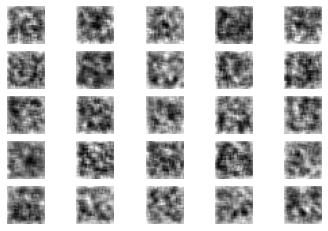

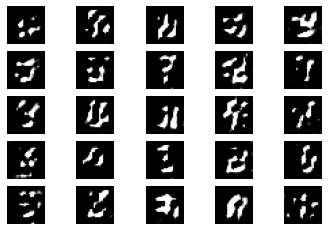

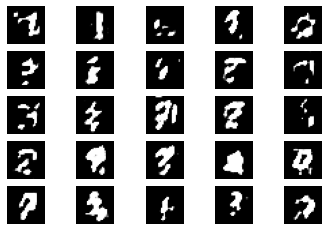

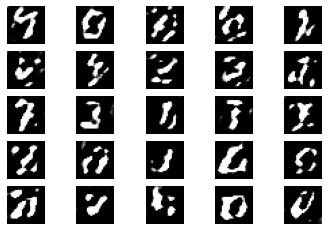

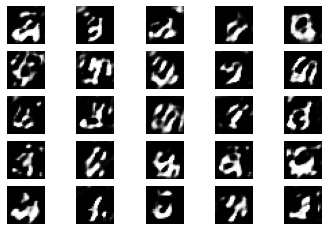

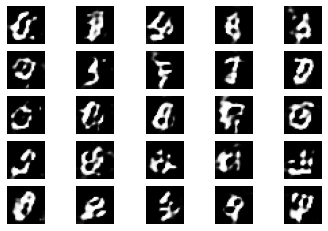

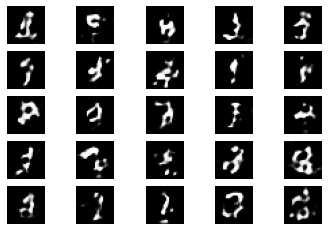

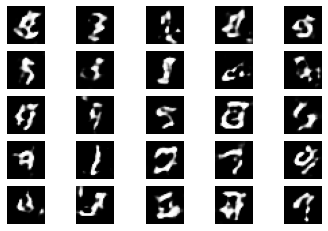

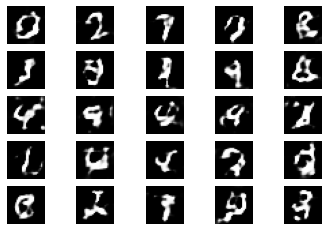

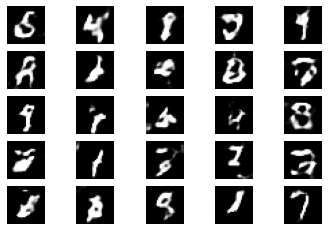

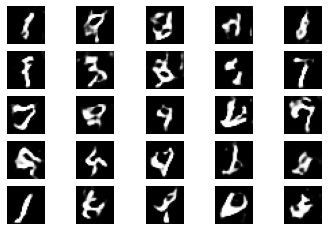

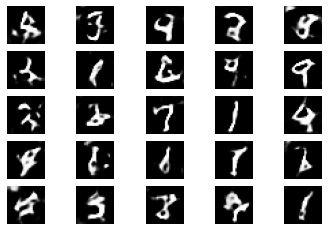

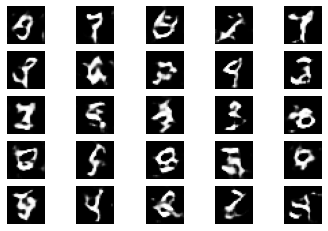

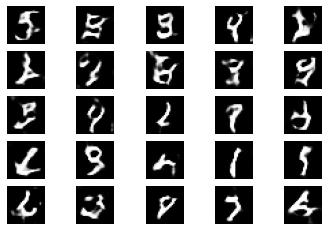

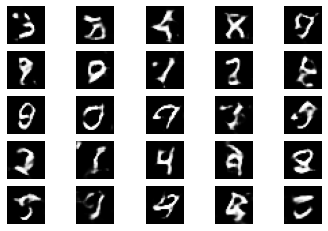

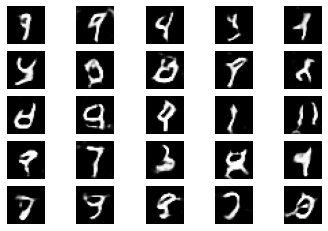

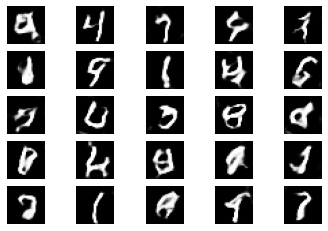

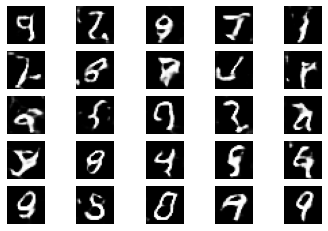

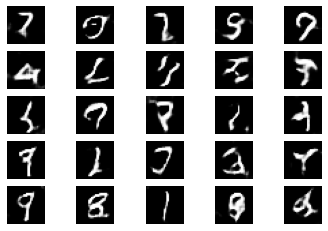

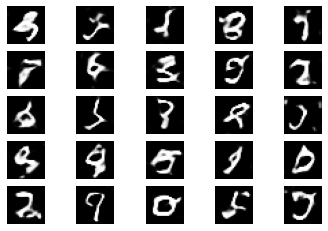

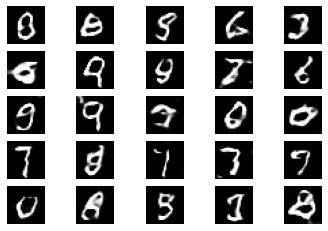

In [6]:
d_loss, g_loss = gan_train(4001, 32, 200)